# 1.Baseline Model Development

## 1.1 Import libraries and download required NLP resources

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

* pandas and numpy: Used for data manipulation and numerical operations.
* nltk (Natural Language Toolkit): Essential library for text preprocessing tasks such as tokenization, removing stopwords, and lemmatization (Bird, Klein, & Loper, 2009).
* sklearn: Provides tools for machine learning tasks, including feature extraction, model training, and evaluation metrics (Pedregosa et al., 2011).

Downloads tokenizers (punkt), English stopwords, WordNet (for lemmatization), and WordNet multilingual support.

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
!unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

Archive:  /root/nltk_data/corpora/wordnet.zip
replace /root/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /root/nltk_data/corpora/wordnet/lexnames  
replace /root/nltk_data/corpora/wordnet/data.verb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /root/nltk_data/corpora/wordnet/data.verb  
  inflating: /root/nltk_data/corpora/wordnet/index.adv  
  inflating: /root/nltk_data/corpora/wordnet/adv.exc  
  inflating: /root/nltk_data/corpora/wordnet/index.verb  
  inflating: /root/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /root/nltk_data/corpora/wordnet/data.adj  
  inflating: /root/nltk_data/corpora/wordnet/index.adj  
  inflating: /root/nltk_data/corpora/wordnet/LICENSE  
  inflating: /root/nltk_data/corpora/wordnet/citation.bib  
  inflating: /root/nltk_data/corpora/wordnet/noun.exc  
  inflating: /root/nltk_data/corpora/wordnet/verb.exc  
  inflating: /root/nltk_data/corpora/wordnet/README  
  inflating: /root/nltk_data/corpora/

## 1.2 Load the Datasets

In [ ]:
# Load CSV files
train_df = pd.read_csv('/content/sample_data/disaster_response_messages_training.csv')
val_df = pd.read_csv('/content/sample_data/disaster_response_messages_validation.csv')
test_df = pd.read_csv('/content/sample_data/disaster_response_messages_test.csv')
# Preview
train_df.head()

<ipython-input-13-17b506af2701>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/sample_data/disaster_response_messages_training.csv')


,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


Loads training and test datasets into pandas DataFrames for further preprocessing and model training.

 ## 1.3 Basic Data Overview

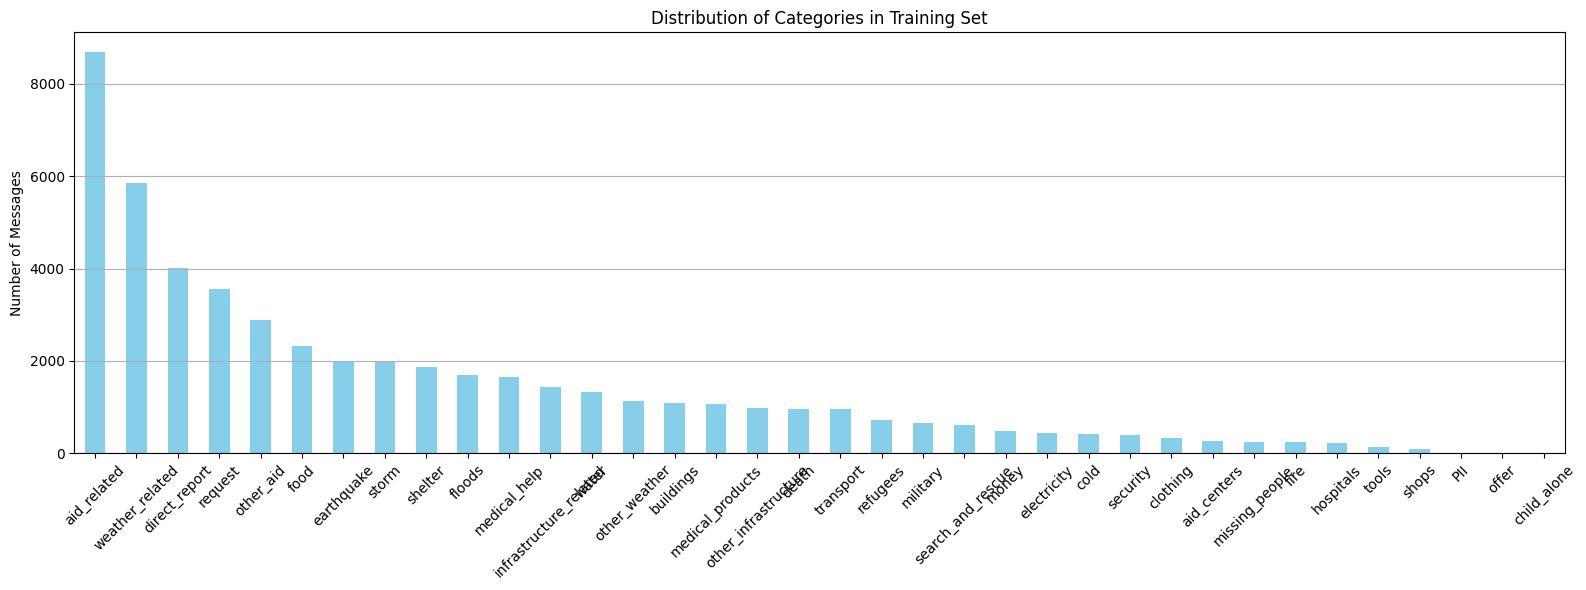

In [ ]:
import matplotlib.pyplot as plt

# Get category columns (from 'related' onwards)
category_columns = train_df.columns[6:]

# Sum and plot
train_df[category_columns].sum().sort_values(ascending=False).plot(
    kind='bar',
    figsize=(16, 6),
    title='Distribution of Categories in Training Set',
    color='skyblue'
)
plt.xticks(rotation=45)
plt.ylabel("Number of Messages")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 1.4 Text Cleaning Function


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)               # Remove digits
    text = re.sub(r'[^\w\s]', '', text)           # Remove punctuation
    tokens = nltk.word_tokenize(text)             # Tokenize words
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]  # Lemmatize & remove stopwords
    return ' '.join(tokens)


* Lowercase normalization.
* Regex used to remove digits and special characters.
* Tokenization splits text into words.
* Stopword removal reduces noise.
* Lemmatization reduces words to their base form (e.g., “running” → “run”), improving feature consistency (Jurafsky & Martin, 2021).

## 1.4 Apply cleaning to messages

In [ ]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
train_df['cleaned_message'] = train_df['message'].astype(str).apply(clean_text)
test_df['cleaned_message'] = test_df['message'].astype(str).apply(clean_text)

Applies the clean_text() function to the message column and stores results in a new column.

## 1.5 TF-IDF Vectorization

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_message'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_message'])

TF-IDF (Term Frequency-Inverse Document Frequency) represents text numerically by measuring the importance of words relative to their frequency in a document and across the corpus. It's effective for sparse, high-dimensional data like text (Manning et al., 2008).

## 1.6 Target Variable Selection

In [ ]:
y_train = train_df['aid_related']
y_test = test_df['aid_related']

Selects the target column for binary classification. The model will learn to predict whether a message is aid-related (1) or not (0).

## 1.7 Define Baseline Models

In [ ]:
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

## 1.8 Train and Evaluate Models

Explanation of Models:
 *  Naïve Bayes: Probabilistic classifier assuming word independence. Fast and effective for text (Manning et al., 2008).
 *  SVM: Finds optimal hyperplanes for class separation in high-dimensional space (Vapnik, 1998).
 *  Logistic Regression: Linear classifier providing class probabilities. Simple and interpretable (Jurafsky & Martin, 2021).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Aid-Related', 'Aid-Related'], yticklabels=['Not Aid-Related', 'Aid-Related'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


Naive Bayes Model Training & Evaluation:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1484
           1       0.79      0.69      0.74      1145

    accuracy                           0.78      2629
   macro avg       0.79      0.77      0.78      2629
weighted avg       0.79      0.78      0.78      2629

[[1273  211]
 [ 355  790]]


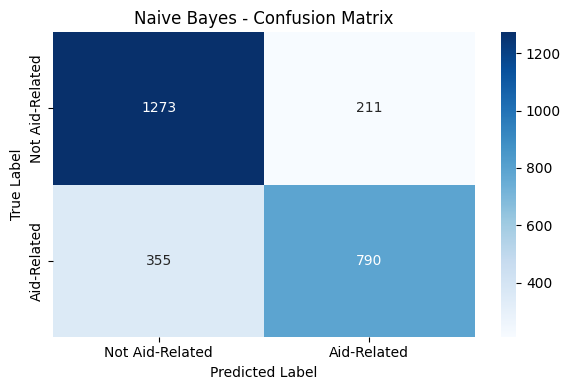


SVM Model Training & Evaluation:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1484
           1       0.79      0.69      0.74      1145

    accuracy                           0.78      2629
   macro avg       0.79      0.77      0.78      2629
weighted avg       0.78      0.78      0.78      2629

[[1275  209]
 [ 358  787]]


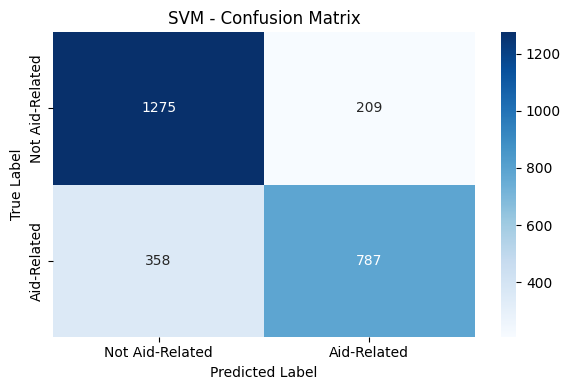


Logistic Regression Model Training & Evaluation:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1484
           1       0.83      0.67      0.74      1145

    accuracy                           0.80      2629
   macro avg       0.80      0.78      0.79      2629
weighted avg       0.80      0.80      0.79      2629

[[1322  162]
 [ 373  772]]


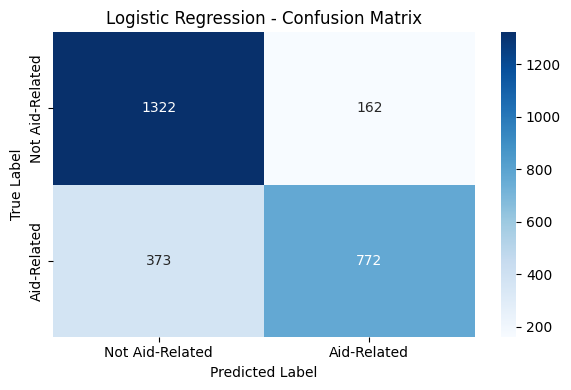

In [ ]:
for name, model in models.items():
    print(f"\n{name} Model Training & Evaluation:")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Print classification metrics
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, name)

# 2. Advanced Model Development

## 2.1 Import needed Modules

In [ ]:
!pip install datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from datasets import Dataset
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

AutoTokenizer, AutoModelForSequenceClassification: Automatically load pre-trained models like BERT/RoBERTa.

Trainer: High-level API for training and evaluation.

datasets.Dataset: Used to structure data into Hugging Face-compatible format.

## 2.2 Prepare Data for Transformers

In [ ]:
train_texts = train_df['message'].astype(str).tolist()
test_texts = test_df['message'].astype(str).tolist()
train_labels = train_df['aid_related'].tolist()
test_labels = test_df['aid_related'].tolist()

We use the raw messages (not TF-IDF) because transformer models handle text directly via tokenization.

## 2.3 Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels}).map(tokenize_function, batched=True)
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels}).map(tokenize_function, batched=True)


Map:   0%|          | 0/21046 [00:00<?, ? examples/s]

Map:   0%|          | 0/2629 [00:00<?, ? examples/s]

This step converts raw text into token IDs, adds special tokens ([CLS], [SEP]), and ensures consistent input lengths. This allows the transformer model to understand sentence structure and context (Devlin et al., 2019).


## 2.4 Load Pre-trained Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This loads BERT with a classification head for binary classification (aid_related: yes/no). You can easily switch to 'roberta-base' here for RoBERTa.

## 2.5 Define Evaluation Metrics

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

This function calculates performance metrics for model evaluation.

## 2.6 Training Configuration

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

Configures the training loop:

* 3 epochs,
* Learning rate: 2e-5 (standard for BERT),
* Batch size: 16,
* Evaluation and saving occur after every epoch.

## 2.7 Training the Model

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mr-spider17 (mr-spider17-university-of-east-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.437900,0.380429,0.828072,0.767981,0.867249,0.814602
2,0.328900,0.384326,0.837961,0.795885,0.844541,0.819492
3,0.234900,0.484806,0.837200,0.807198,0.822707,0.814879


TrainOutput(global_step=3948, training_loss=0.33747112618149716, metrics={'train_runtime': 5917.0315, 'train_samples_per_second': 10.671, 'train_steps_per_second': 0.667, 'total_flos': 1.661230581331968e+16, 'train_loss': 0.33747112618149716, 'epoch': 3.0})

This command fine-tunes the transformer model on your disaster response dataset, using the Trainer API to handle optimization, batching, and evaluation automatically.

## 2.8 Evaluation

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.4848059415817261, 'eval_accuracy': 0.8372004564473183, 'eval_precision': 0.8071979434447301, 'eval_recall': 0.8227074235807861, 'eval_f1': 0.8148788927335641, 'eval_runtime': 80.0827, 'eval_samples_per_second': 32.829, 'eval_steps_per_second': 2.06, 'epoch': 3.0}


Displays metrics like accuracy, precision, recall, and F1-score on the test set.

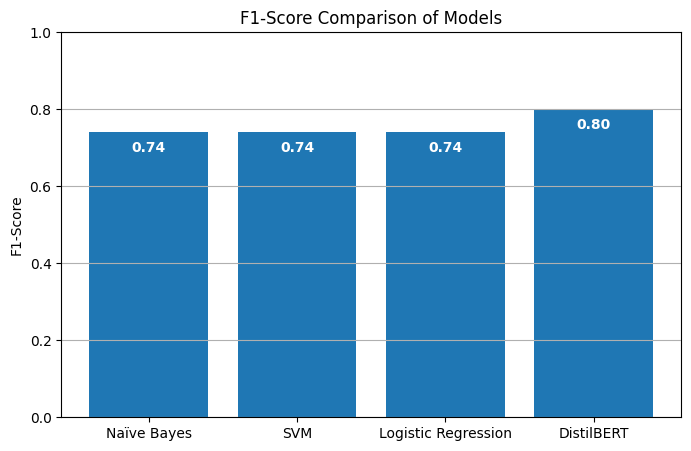

In [ ]:
import matplotlib.pyplot as plt

models = ['Naïve Bayes', 'SVM', 'Logistic Regression', 'DistilBERT']
f1_scores = [0.74, 0.74, 0.74, 0.80]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, f1_scores)
plt.ylim(0, 1)
plt.title('F1-Score Comparison of Models')
plt.ylabel('F1-Score')
plt.grid(axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height - 0.05, f'{height:.2f}', ha='center', color='white', fontweight='bold')

plt.show()
